## 70. 単語ベクトルの和による特徴量
学習、検証、評価データについて特徴量行列とラベル行列を作成し保存せよ
問題50で作成したデータを使用する

In [1]:
import pandas as pd

DATA_PATH = "./data/news_aggregator_dataset/"

train_df = pd.read_csv(DATA_PATH + "train.txt", delimiter="\t")
valid_df = pd.read_csv(DATA_PATH + "valid.txt", delimiter="\t")
test_df = pd.read_csv(DATA_PATH + "test.txt", delimiter="\t")

print(train_df.head())

  CATEGORY                                              TITLE
0        b  Airline Mergers Pushed JetBlue's Pilots to Joi...
1        e      Andrew Garfield wants Black-HispanicSpiderman
2        b  Korean Bonds Fall as Choi Refrains From Signal...
3        m  REFILE-AstraZeneca fights to regain cancer mar...
4        e  Beyonce and Solange both take the plunge at fi...


In [2]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("./data/GoogleNews-vectors-negative300.bin.gz", binary=True)
print(model["test"])

[-1.42578125e-01 -3.68652344e-02  1.35742188e-01 -6.20117188e-02
  7.95898438e-02  1.90429688e-02 -8.15429688e-02 -1.27929688e-01
 -2.95410156e-02  2.36328125e-01 -1.21582031e-01 -2.14843750e-01
  1.29882812e-01 -2.70996094e-02 -5.20019531e-02  2.15820312e-01
 -1.81640625e-01  5.10253906e-02 -1.60156250e-01 -1.76757812e-01
  1.83105469e-02 -4.12597656e-02 -2.32421875e-01 -1.03149414e-02
  1.45507812e-01  5.24902344e-02 -3.96484375e-01 -1.92871094e-02
  2.51770020e-03 -1.26953125e-02 -4.39453125e-02  3.07617188e-02
  9.57031250e-02 -1.75781250e-01  1.04370117e-02  1.89453125e-01
 -2.36328125e-01  4.37011719e-02  2.81250000e-01 -2.07519531e-02
 -1.81640625e-01 -2.17773438e-01  2.33398438e-01  5.29785156e-02
 -1.13769531e-01  9.39941406e-03 -1.49414062e-01  1.99218750e-01
 -1.75781250e-01  3.16406250e-01  8.10546875e-02 -6.12792969e-02
 -1.52343750e-01 -1.81884766e-02  8.25195312e-02  8.74023438e-02
 -1.18652344e-01 -2.59765625e-01 -1.68457031e-02  1.87988281e-02
  1.36108398e-02 -2.39257

In [3]:
import string
import torch

def t_word2vec(text:str):
    table = str.maketrans(string.punctuation, " "*len(string.punctuation))
    words = text.translate(table).split()
    vec = [model[word] for word in words if word in model]

    return torch.tensor(sum(vec) / len(vec))

/home/morioka/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
x_train = torch.stack([t_word2vec(text) for text in train_df["TITLE"]])
x_valid = torch.stack([t_word2vec(text) for text in valid_df["TITLE"]])
x_test = torch.stack([t_word2vec(text) for text in test_df["TITLE"]])

print(x_train.size())
print(x_valid.size())
print(x_test.size())
print(x_train)

torch.Size([10684, 300])
torch.Size([1336, 300])
torch.Size([1336, 300])
tensor([[-0.0320,  0.0469, -0.1285,  ...,  0.0598,  0.0706,  0.0334],
        [ 0.1342,  0.0461, -0.0732,  ...,  0.0004,  0.0495, -0.0385],
        [ 0.0102,  0.1922, -0.0510,  ...,  0.0321,  0.0804,  0.0190],
        ...,
        [ 0.0596, -0.0215, -0.0660,  ..., -0.0506,  0.0126, -0.0528],
        [ 0.0660,  0.1197,  0.0617,  ..., -0.0637,  0.0367,  0.0248],
        [ 0.0409, -0.0189,  0.0151,  ..., -0.0743,  0.0713, -0.1081]])


In [5]:
category_dict = {"b":0, "t":1, "e":2, "m":3}
y_train = torch.tensor(train_df["CATEGORY"].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid_df["CATEGORY"].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test_df["CATEGORY"].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_valid.size())
print(y_test.size())
print(y_train)

torch.Size([10684])
torch.Size([1336])
torch.Size([1336])
tensor([0, 2, 0,  ..., 2, 2, 2])


In [6]:
torch.save(x_train, DATA_PATH + "x_train.pt")
torch.save(x_valid, DATA_PATH + "x_valid.pt")
torch.save(x_test, DATA_PATH + "x_test.pt")
torch.save(y_train, DATA_PATH + "y_train.pt")
torch.save(y_valid, DATA_PATH + "y_valid.pt")
torch.save(y_test, DATA_PATH + "y_test.pt")

## 71. 単層ニューラルネットワークによる予測

In [7]:
from torch import nn

class SLPNet(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        nn.init.normal_(self.fc.weight, 0.0, 1.0) # 正規乱数で重みを初期化
    
    def forward(self, x):
        x = self.fc(x)
        return x

In [8]:
model = SLPNet(300, 4)
y_hat_1 = torch.softmax(model(x_train[:1]), dim=1)
Y_hat = torch.softmax(model(x_train[:4]), dim=1)

print(y_hat_1)
print(Y_hat)

tensor([[0.0825, 0.0121, 0.9034, 0.0020]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0825, 0.0121, 0.9034, 0.0020],
        [0.1487, 0.0594, 0.4864, 0.3055],
        [0.0253, 0.8962, 0.0058, 0.0727],
        [0.5301, 0.2065, 0.1004, 0.1630]], grad_fn=<SoftmaxBackward0>)


## 72. 損失と勾配の計算
クロスエントロピー損失と行列Wに対する勾配を求める

In [9]:
criterion = nn.CrossEntropyLoss()

l_1 = criterion(model(x_train[:1]), y_train[:1])
model.zero_grad()
l_1.backward()

print(f"損失：{l_1: .4f}")
print(f"勾配：\n{model.fc.weight.grad}")

損失： 2.4945
勾配：
tensor([[ 2.9315e-02, -4.3006e-02,  1.1789e-01,  ..., -5.4825e-02,
         -6.4747e-02, -3.0617e-02],
        [-3.8627e-04,  5.6667e-04, -1.5534e-03,  ...,  7.2240e-04,
          8.5314e-04,  4.0342e-04],
        [-2.8865e-02,  4.2347e-02, -1.1609e-01,  ...,  5.3985e-02,
          6.3755e-02,  3.0147e-02],
        [-6.2949e-05,  9.2350e-05, -2.5316e-04,  ...,  1.1773e-04,
          1.3904e-04,  6.5745e-05]])


In [10]:
l_4 = criterion(model(x_train[:4]), y_train[:4])
model.zero_grad()
l_4.backward()

print(f"損失：{l_4: .4f}")
print(f"勾配：\n{model.fc.weight.grad}")

損失： 2.1769
勾配：
tensor([[ 0.0077, -0.0368,  0.0287,  ..., -0.0035, -0.0309, -0.0185],
        [ 0.0033,  0.0513, -0.0170,  ...,  0.0144,  0.0201,  0.0019],
        [-0.0248,  0.0086, -0.0217,  ...,  0.0169,  0.0103,  0.0116],
        [ 0.0138, -0.0231,  0.0100,  ..., -0.0278,  0.0005,  0.0049]])


## 73. 確率的勾配降下法による学習

In [11]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, X, y) -> None:
        super().__init__()
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [12]:
from torch.utils.data import DataLoader

dataset_train = NewsDataset(x_train, y_train)
dataset_valid = NewsDataset(x_valid, y_valid)
dataset_test = NewsDataset(x_test, y_test)

train_loader = DataLoader(dataset_train, batch_size=1, shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [13]:
model = SLPNet(300, 4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    loss_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
    
    loss_train /= len(train_loader)

    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(valid_loader))
        outputs = model(inputs)
        loss_valid = criterion(outputs, labels)
    
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

epoch: 1, loss_train: 0.4488, loss_valid: 0.3546
epoch: 2, loss_train: 0.3012, loss_valid: 0.3295
epoch: 3, loss_train: 0.2751, loss_valid: 0.3241
epoch: 4, loss_train: 0.2606, loss_valid: 0.3156
epoch: 5, loss_train: 0.2507, loss_valid: 0.3216
epoch: 6, loss_train: 0.2443, loss_valid: 0.3103
epoch: 7, loss_train: 0.2393, loss_valid: 0.3099
epoch: 8, loss_train: 0.2347, loss_valid: 0.3112
epoch: 9, loss_train: 0.2315, loss_valid: 0.3075
epoch: 10, loss_train: 0.2286, loss_valid: 0.3081
epoch: 11, loss_train: 0.2263, loss_valid: 0.3124
epoch: 12, loss_train: 0.2247, loss_valid: 0.3091
epoch: 13, loss_train: 0.2230, loss_valid: 0.3108
epoch: 14, loss_train: 0.2208, loss_valid: 0.3095
epoch: 15, loss_train: 0.2195, loss_valid: 0.3156
epoch: 16, loss_train: 0.2178, loss_valid: 0.3116
epoch: 17, loss_train: 0.2166, loss_valid: 0.3124
epoch: 18, loss_train: 0.2163, loss_valid: 0.3120
epoch: 19, loss_train: 0.2157, loss_valid: 0.3146
epoch: 20, loss_train: 0.2141, loss_valid: 0.3149
epoch: 21

## 74. 正解率の計測

In [14]:
def calculate_accuracy(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
    return correct / total

accuracy_train = calculate_accuracy(model, train_loader)
accuracy_test = calculate_accuracy(model, test_loader)
print(f'正解率（学習データ）：{accuracy_train:.3f}')
print(f'正解率（評価データ）：{accuracy_test:.3f}')


正解率（学習データ）：0.927
正解率（評価データ）：0.894


## 75. 損失と正解率のプロット

In [15]:
def calculate_loss_and_accuracy(model, criterion, loader):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
    return loss / len(loader), correct / total

In [16]:
model = SLPNet(300, 4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

log_train = []
log_valid = []

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    loss_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    loss_train, accuracy_train = calculate_loss_and_accuracy(model, criterion, train_loader)
    loss_valid, accuracy_valid = calculate_loss_and_accuracy(model, criterion, valid_loader)

    log_train.append([loss_train, accuracy_train])
    log_valid.append([loss_valid, accuracy_valid])
    
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {accuracy_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {accuracy_valid:.4f}')  

epoch: 1, loss_train: 0.3320, accuracy_train: 0.8900, loss_valid: 0.3770, accuracy_valid: 0.8668
epoch: 2, loss_train: 0.2785, accuracy_train: 0.9050, loss_valid: 0.3355, accuracy_valid: 0.8877
epoch: 3, loss_train: 0.2612, accuracy_train: 0.9114, loss_valid: 0.3256, accuracy_valid: 0.8915
epoch: 4, loss_train: 0.2515, accuracy_train: 0.9164, loss_valid: 0.3227, accuracy_valid: 0.8930
epoch: 5, loss_train: 0.2403, accuracy_train: 0.9189, loss_valid: 0.3145, accuracy_valid: 0.8960
epoch: 6, loss_train: 0.2336, accuracy_train: 0.9218, loss_valid: 0.3124, accuracy_valid: 0.8982
epoch: 7, loss_train: 0.2309, accuracy_train: 0.9205, loss_valid: 0.3112, accuracy_valid: 0.9004
epoch: 8, loss_train: 0.2280, accuracy_train: 0.9217, loss_valid: 0.3143, accuracy_valid: 0.8982
epoch: 9, loss_train: 0.2225, accuracy_train: 0.9241, loss_valid: 0.3106, accuracy_valid: 0.8990
epoch: 10, loss_train: 0.2211, accuracy_train: 0.9236, loss_valid: 0.3116, accuracy_valid: 0.8982
epoch: 11, loss_train: 0.2176

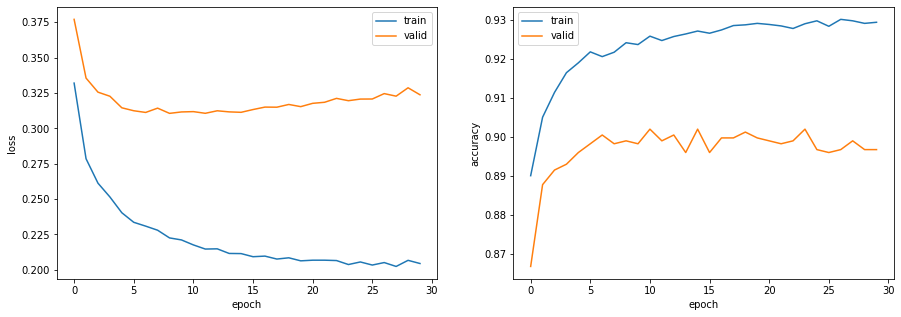

In [17]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

## 76.チェックポイント
各エポックでチェックポイントファイルを書き出す

In [19]:
model = SLPNet(300, 4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

log_train = []
log_valid = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    loss_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    loss_train, accuracy_train = calculate_loss_and_accuracy(model, criterion, train_loader)
    loss_valid, accuracy_valid = calculate_loss_and_accuracy(model, criterion, valid_loader)

    log_train.append([loss_train, accuracy_train])
    log_valid.append([loss_valid, accuracy_valid])

    torch.save({"epoch": epoch, "model_state_dict":model.state_dict(), "optimizer_state_dict":optimizer.state_dict()}, f"./data/checkpoints/checkpoint{epoch + 1}.pt")
    
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {accuracy_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {accuracy_valid:.4f}')  

epoch: 1, loss_train: 0.3285, accuracy_train: 0.8841, loss_valid: 0.3587, accuracy_valid: 0.8720
epoch: 2, loss_train: 0.2841, accuracy_train: 0.9038, loss_valid: 0.3279, accuracy_valid: 0.8840
epoch: 3, loss_train: 0.2661, accuracy_train: 0.9107, loss_valid: 0.3197, accuracy_valid: 0.8877
epoch: 4, loss_train: 0.2487, accuracy_train: 0.9136, loss_valid: 0.3093, accuracy_valid: 0.8967
epoch: 5, loss_train: 0.2431, accuracy_train: 0.9171, loss_valid: 0.3099, accuracy_valid: 0.8952
epoch: 6, loss_train: 0.2353, accuracy_train: 0.9199, loss_valid: 0.3085, accuracy_valid: 0.8982
epoch: 7, loss_train: 0.2330, accuracy_train: 0.9212, loss_valid: 0.3089, accuracy_valid: 0.8975
epoch: 8, loss_train: 0.2262, accuracy_train: 0.9230, loss_valid: 0.3055, accuracy_valid: 0.9004
epoch: 9, loss_train: 0.2234, accuracy_train: 0.9244, loss_valid: 0.3069, accuracy_valid: 0.9012
epoch: 10, loss_train: 0.2195, accuracy_train: 0.9250, loss_valid: 0.3056, accuracy_valid: 0.9019


## 77. ミニバッチ化

In [24]:
import time

def train_model(batch_size, model, num_epochs, criterion, optimizer):
    log_train = []
    log_valid = []

    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()
        loss_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        loss_train, accuracy_train = calculate_loss_and_accuracy(model, criterion, train_loader)
        loss_valid, accuracy_valid = calculate_loss_and_accuracy(model, criterion, valid_loader)

        log_train.append([loss_train, accuracy_train])
        log_valid.append([loss_valid, accuracy_valid])

        torch.save({"epoch": epoch, "model_state_dict":model.state_dict(), "optimizer_state_dict":optimizer.state_dict()}, f"./data/checkpoints/checkpoint{epoch + 1}.pt")

        e_time = time.time()

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {accuracy_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {accuracy_valid:.4f}, {(e_time - s_time): .4f}sec')  

In [26]:
model = SLPNet(300, 4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

for batch_size in [2 ** i for i in range(10)]:
    print(f"batch_size : {batch_size}")
    train_model(batch_size, model, 1, criterion, optimizer)

batch_size : 1
epoch: 1, loss_train: 0.3281, accuracy_train: 0.8884, loss_valid: 0.3604, accuracy_valid: 0.8817,  3.5071sec
batch_size : 2
epoch: 1, loss_train: 0.2985, accuracy_train: 0.8984, loss_valid: 0.3392, accuracy_valid: 0.8862,  1.9403sec
batch_size : 4
epoch: 1, loss_train: 0.2885, accuracy_train: 0.8993, loss_valid: 0.3336, accuracy_valid: 0.8832,  1.0302sec
batch_size : 8
epoch: 1, loss_train: 0.2835, accuracy_train: 0.9014, loss_valid: 0.3304, accuracy_valid: 0.8877,  0.5753sec
batch_size : 16
epoch: 1, loss_train: 0.2815, accuracy_train: 0.9025, loss_valid: 0.3288, accuracy_valid: 0.8855,  0.3526sec
batch_size : 32
epoch: 1, loss_train: 0.2805, accuracy_train: 0.9030, loss_valid: 0.3279, accuracy_valid: 0.8862,  0.2442sec
batch_size : 64
epoch: 1, loss_train: 0.2802, accuracy_train: 0.9035, loss_valid: 0.3276, accuracy_valid: 0.8862,  0.2381sec
batch_size : 128
epoch: 1, loss_train: 0.2803, accuracy_train: 0.9036, loss_valid: 0.3275, accuracy_valid: 0.8862,  0.6648sec
bat

## 78. GPU上での学習

In [27]:
def calculate_loss_and_accuracy_gpu(model, criterion, loader, device):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
    return loss / len(loader), correct / total

In [28]:
import time

def train_model_gpu(batch_size, model, num_epochs, criterion, optimizer, device):
    model.to(device)

    log_train = []
    log_valid = []

    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()
        loss_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        loss_train, accuracy_train = calculate_loss_and_accuracy_gpu(model, criterion, train_loader, device)
        loss_valid, accuracy_valid = calculate_loss_and_accuracy_gpu(model, criterion, valid_loader, device)

        log_train.append([loss_train, accuracy_train])
        log_valid.append([loss_valid, accuracy_valid])

        torch.save({"epoch": epoch, "model_state_dict":model.state_dict(), "optimizer_state_dict":optimizer.state_dict()}, f"./data/checkpoints/checkpoint{epoch + 1}.pt")

        e_time = time.time()

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {accuracy_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {accuracy_valid:.4f}, {(e_time - s_time): .4f}sec')  

In [30]:
model = SLPNet(300, 4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

device = "cuda" if torch.cuda.is_available() else "cpu"

for batch_size in [2 ** i for i in range(10)]:
    print(f"batch_size : {batch_size}")
    train_model_gpu(batch_size, model, 1, criterion, optimizer, device)

batch_size : 1
epoch: 1, loss_train: 0.3280, accuracy_train: 0.8885, loss_valid: 0.3678, accuracy_valid: 0.8750,  18.0530sec
batch_size : 2
epoch: 1, loss_train: 0.2981, accuracy_train: 0.8970, loss_valid: 0.3468, accuracy_valid: 0.8810,  8.9668sec
batch_size : 4
epoch: 1, loss_train: 0.2903, accuracy_train: 0.8990, loss_valid: 0.3418, accuracy_valid: 0.8802,  4.5577sec
batch_size : 8
epoch: 1, loss_train: 0.2853, accuracy_train: 0.9014, loss_valid: 0.3377, accuracy_valid: 0.8832,  2.4085sec
batch_size : 16
epoch: 1, loss_train: 0.2831, accuracy_train: 0.9015, loss_valid: 0.3355, accuracy_valid: 0.8840,  1.2015sec
batch_size : 32
epoch: 1, loss_train: 0.2822, accuracy_train: 0.9016, loss_valid: 0.3349, accuracy_valid: 0.8840,  0.6535sec
batch_size : 64
epoch: 1, loss_train: 0.2819, accuracy_train: 0.9016, loss_valid: 0.3346, accuracy_valid: 0.8840,  0.3534sec
batch_size : 128
epoch: 1, loss_train: 0.2826, accuracy_train: 0.9015, loss_valid: 0.3345, accuracy_valid: 0.8840,  0.2249sec
ba

## 79. 多層ニューラルネットワーク

In [76]:
from torch.nn import functional as F

class MLPNet(nn.Module):
    def __init__(self, input_size, mid_size, output_size, mid_layers) -> None:
        super().__init__()

        self.mid_layers = mid_layers
        self.fc_first = nn.Linear(input_size, mid_size)
        self.fc_mid = nn.Linear(mid_size, mid_size)
        self.fc_out = nn.Linear(mid_size, output_size)
        self.bn = nn.BatchNorm1d(mid_size)
    
    def forward(self, x):
        t_vec = F.relu(self.fc_first(x))
        for _ in range(self.mid_layers):
            t_vec = F.relu(self.bn(self.fc_mid(t_vec)))
        t_vec = F.relu(self.fc_out(t_vec))

        return t_vec


In [101]:
import time

def train_model_gpu_kai(batch_size, model, num_epochs, criterion, optimizer, device, start_save_model, tolerance):
    model.to(device)

    log_train = []
    log_valid = []

    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    #scheculer = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

    best_valid_loss = 100
    tolerance_count = 0

    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()
        loss_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        loss_train, accuracy_train = calculate_loss_and_accuracy_gpu(model, criterion, train_loader, device)
        loss_valid, accuracy_valid = calculate_loss_and_accuracy_gpu(model, criterion, valid_loader, device)

        log_train.append([loss_train, accuracy_train])
        log_valid.append([loss_valid, accuracy_valid])

        if loss_valid < best_valid_loss:
            best_valid_loss = loss_valid
            tolerance_count = 0
            if epoch > start_save_model:
                torch.save({"epoch": epoch, "model_state_dict":model.state_dict(), "optimizer_state_dict":optimizer.state_dict()}, f"./data/checkpoints/79_best.pt")
        else:
            tolerance_count += 1

        e_time = time.time()

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {accuracy_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {accuracy_valid:.4f}, 許容値：{tolerance_count}/{tolerance}, {(e_time - s_time): .4f}sec')

        if tolerance_count > tolerance:
            break

        #scheculer.step()

    return {'train': log_train, 'valid': log_valid}

In [104]:
model = MLPNet(300, 200, 4, 1)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

log = train_model_gpu_kai(64, model, 100, criterion, optimizer, device, 1, 20)

epoch: 1, loss_train: 0.8605, accuracy_train: 0.7568, loss_valid: 0.8596, accuracy_valid: 0.7635, 許容値：0/20,  0.5524sec
epoch: 2, loss_train: 0.7042, accuracy_train: 0.7735, loss_valid: 0.7085, accuracy_valid: 0.7769, 許容値：0/20,  0.5222sec
epoch: 3, loss_train: 0.6441, accuracy_train: 0.7775, loss_valid: 0.6520, accuracy_valid: 0.7792, 許容値：0/20,  0.5258sec
epoch: 4, loss_train: 0.6030, accuracy_train: 0.7817, loss_valid: 0.6145, accuracy_valid: 0.7837, 許容値：0/20,  0.5193sec
epoch: 5, loss_train: 0.5672, accuracy_train: 0.7890, loss_valid: 0.5822, accuracy_valid: 0.7882, 許容値：0/20,  0.5128sec
epoch: 6, loss_train: 0.5382, accuracy_train: 0.7978, loss_valid: 0.5563, accuracy_valid: 0.7972, 許容値：0/20,  0.5786sec
epoch: 7, loss_train: 0.5166, accuracy_train: 0.8128, loss_valid: 0.5377, accuracy_valid: 0.8024, 許容値：0/20,  0.5247sec
epoch: 8, loss_train: 0.4957, accuracy_train: 0.8207, loss_valid: 0.5175, accuracy_valid: 0.8151, 許容値：0/20,  0.5083sec
epoch: 9, loss_train: 0.4787, accuracy_train: 0.

In [92]:
def calculate_accuracy_gpu(model, loader, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
    return correct / total

In [105]:
acc_train = calculate_accuracy_gpu(model, train_loader, device)
acc_test = calculate_accuracy_gpu(model, test_loader, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.950
正解率（評価データ）：0.901


In [106]:
model.load_state_dict(torch.load("./data/checkpoints/79_best.pt")["model_state_dict"])

acc_train = calculate_accuracy_gpu(model, train_loader, device)
acc_test = calculate_accuracy_gpu(model, test_loader, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.949
正解率（評価データ）：0.903
